# Important note before running this code
This code assumes that the data preperation notebook was executed before and hence the sql database accessed underneath, is already populated

In [1]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt

In [3]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [5]:
print(pd.read_sql('SELECT * FROM cases',db_conn))

     iso_code       date  new_cases_per_million  \
0         ITA 2020-01-31                  0.034   
1         ITA 2020-02-01                  0.000   
2         ITA 2020-02-02                  0.000   
3         ITA 2020-02-03                  0.000   
4         ITA 2020-02-04                  0.000   
...       ...        ...                    ...   
2953      NLD 2022-10-14                630.796   
2954      NLD 2022-10-15                  0.000   
2955      NLD 2022-10-16                  0.000   
2956      NLD 2022-10-17                  1.828   
2957      NLD 2022-10-18                665.136   

      new_cases_smoothed_per_million  reproduction_rate  
0                                NaN                NaN  
1                                NaN                NaN  
2                                NaN                NaN  
3                                NaN                NaN  
4                                NaN                NaN  
...                              ...   

In [125]:
class Analytics:
    def __init__(self, db_conn,mainView):
        self.db_conn = db_conn
        self.mainView = mainView
    def KPI_policy_covar(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        kpi , policy = self.__formatColumns(kpiColName,policyColName,daysAhead)
        covar = np.cov(kpi,policy)
        return covar
    def KPI_policy_plot(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        kpi , policy = self.__formatColumns(kpiColName,policyColName,daysAhead)
        plt.scatter(kpi,policy)
        plt.xlabel(kpiColName)
        plt.ylabel(policyColName)
        plt.title(policyColName + ' for ' + kpiColName + ' ' + str(daysAhead) +' days before')
        plt.show()
    def KPIs_policy_covars_and_plots(self, kpiColNameList, policyColName = 'event_cancellation_level', daysAhead = 14):
        for kpiName in kpiColNameList:
            print(kpiName)
            print(self.KPI_policy_covar(kpiName,policyColName,daysAhead))
            self.KPI_policy_plot(kpiName,policyColName,daysAhead)
    def __formatColumns(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        kpi = np.array(pd.read_sql('SELECT ' + kpiColName + ' FROM ' + self.mainView, self.db_conn)[kpiColName])
        policy = np.array(pd.read_sql('SELECT ' + policyColName + ' FROM ' + self.mainView, self.db_conn)[policyColName])
        #making kpi and policy columns of equal length such that for each i kpi[i] is the value of this kpi...
        #... N days before the policy level was at policy[i], where N = daysAhead.
        policy = policy[daysAhead:]
        kpi = kpi[:-daysAhead]
        toDelete = []
       
        for i in range(len(policy)):
            if np.isnan(policy[i]) or np.isnan(kpi[i]):
                toDelete.append(i)
        kpi = np.delete(kpi,toDelete)
        policy = np.delete(policy,toDelete)
        return (kpi,policy)
    
    

In [126]:
analytics = Analytics(db_conn,'all_relevant')

new_cases_smoothed_per_million
[[ 4.66772019e+05 -9.01232431e+01]
 [-9.01232431e+01  2.62166590e+00]]


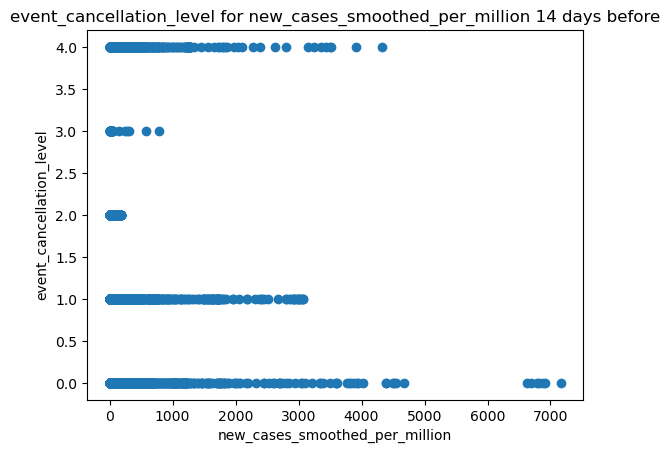

reproduction_rate
[[0.14868029 0.04830307]
 [0.04830307 2.60092303]]


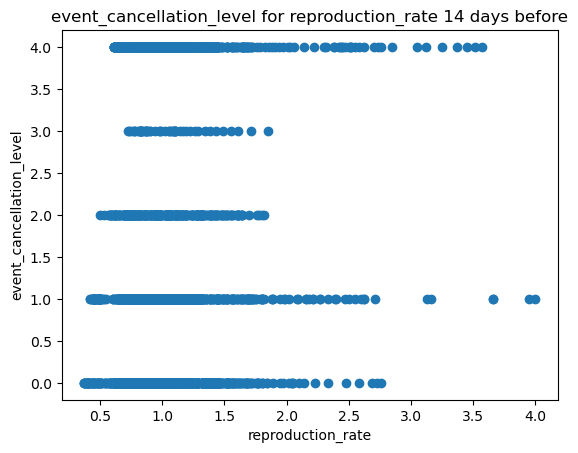

icu_patients_per_million
[[321.03132089  19.94333045]
 [ 19.94333045   3.03396047]]


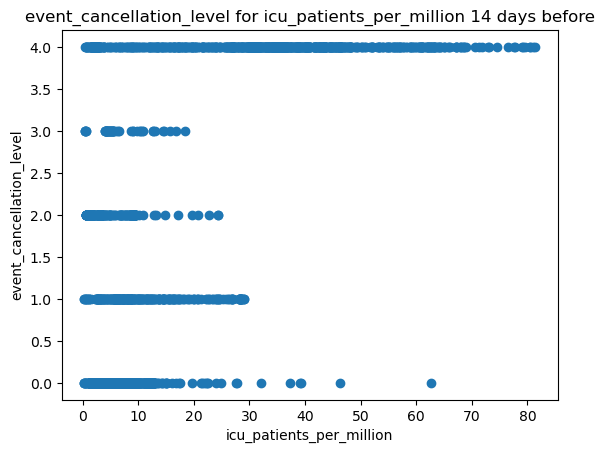

In [130]:
analytics.KPIs_policy_covars_and_plots(['new_cases_smoothed_per_million','reproduction_rate','icu_patients_per_million'])

In [129]:
analytics.KPI_policy_covar('new_cases_smoothed_per_million')

array([[ 4.66772019e+05, -9.01232431e+01],
       [-9.01232431e+01,  2.62166590e+00]])

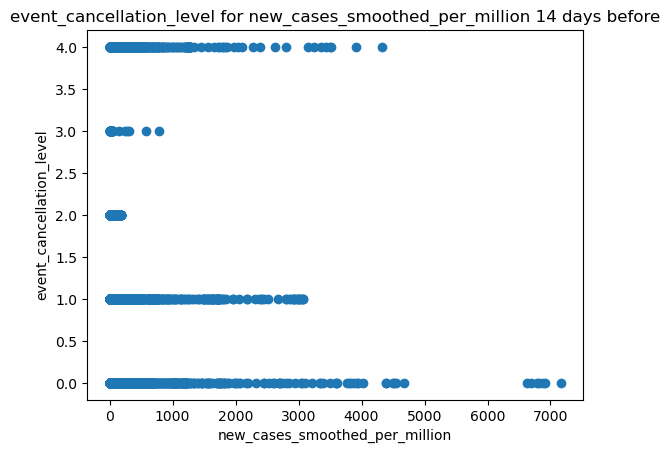

In [111]:
analytics.KPI_policy_plot('new_cases_smoothed_per_million',daysAhead=14)

In [84]:
pd.unique(pd.read_sql('SELECT ' + 'event_cancellation_level'+ ' FROM all_relevant', db_conn)['event_cancellation_level'])

array([ 0.,  2.,  1., nan])